**Purpose**: The Paycheck Protection Program (PPP) is a $1 trillion business loan program established by the US federal 
government in 2020 to help business and sole proprietors continue paying their workers. The purpose of this file is to do an analysis in order at the end to create a report on financial aid provided to US business during COVID.So, in general, in this project, we aim to analyze financial aid provided to U.S. businesses during the COVID-19 pandemic using Paycheck Protection Program (PPP) data, job postings data, and population estimates. The steps include downloading data,loading data into python, cleaning, merging, and performing exploratory data analysis (EDA).
I note that in order to run this code you have to download all these files from these links:

1)https://data.sba.gov/dataset/ppp-foia

2)https://github.com/OpportunityInsights/EconomicTracker

3)https://opportunityinsights.org/data/

After you have done this, you have to put in the file path variable, the path where you have saved the PPP data
Also in the folder_path you have to write the path of the folder where you have saved the Data and in output_folder the path that you want to save the new cleaned data that will be created

You will not be able to run this code if you do not download all the necessary files and put them in the same folder.




**Author**: Konstantinos Grammenos

**Date**: 29/5/2024


**LOAD DATA SECTION**


The first thing we did is to load just a sample of rows of just one of the twelve files in order to see the datatypes of each column and in general the structure of the dataset.

In [3]:
import pandas as pd

#the path of just one of the 13 files
file_path = "C:/Users/kosti/OneDrive/Desktop/Data Engineering/Homework2/CovidRecovery/RawData/public_up_to_150k_1_230930.csv"

# Load a small sample of the data,1000 rows
sample_df = pd.read_csv(file_path, nrows=1000)

print(sample_df.info())

print(sample_df.head())
print(sample_df.columns)

# examine if all the values of non profit are: NaN
sample_df['NonProfit'].isna().all()
# count how many NaN values are in NonProfit variable
non_counts_non_profit = sample_df['NonProfit'].isna().sum()
obs_non_profit = len(sample_df['NonProfit'])
print(f"Number of NaN values in 'NonProfit': {non_counts_non_profit}, Total number of observations in 'NonProfit': {obs_non_profit}")

# Calculate the frequency of NaN values
nan_frequency = non_counts_non_profit / obs_non_profit

# Print the results
print(f"Number of NaN values in 'NonProfit': {non_counts_non_profit}")
print(f"Total number of observations in 'NonProfit': {obs_non_profit}")
print(f"Frequency of NaN values in 'NonProfit': {nan_frequency:.2f}")
# examine if SBAGuarantyPercentage has only values = 100
(sample_df['SBAGuarantyPercentage'] == 100).all()
# drop column NonProfit since 98% of its observations are missing, and SBAGuarantyPercentage since all its variables are 100
sample_df = sample_df.drop(columns=['NonProfit', 'SBAGuarantyPercentage'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 53 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LoanNumber                   1000 non-null   int64  
 1   DateApproved                 1000 non-null   object 
 2   SBAOfficeCode                972 non-null    float64
 3   ProcessingMethod             1000 non-null   object 
 4   BorrowerName                 1000 non-null   object 
 5   BorrowerAddress              869 non-null    object 
 6   BorrowerCity                 869 non-null    object 
 7   BorrowerState                848 non-null    object 
 8   BorrowerZip                  869 non-null    object 
 9   LoanStatusDate               991 non-null    object 
 10  LoanStatus                   1000 non-null   object 
 11  Term                         1000 non-null   int64  
 12  SBAGuarantyPercentage        1000 non-null   int64  
 13  InitialApprovalAmou

We observed that in some columns the majority of the values are Nas so we chose not to select those columns

After the first step which we saw the datatype of each column, we created a
dtype_mapping dictionary in order to define the data types for each column
when loading the dataset. We did this so to optimize memory usage and ensure that all the columns have the datatype that they dhould have.


In [4]:
dtype_mapping = {
    'LoanNumber': 'str', 'DateApproved': 'str', 'BorrowerCity': 'str', 'BorrowerState': 'category',
    'BorrowerZip': 'str', 'LoanStatusDate': 'str', 'LoanStatus': 'category', 'Term': 'Int32',
    'InitialApprovalAmount': 'float32', 'CurrentApprovalAmount': 'float32',
    'UndisbursedAmount': 'float32', 'ServicingLenderName': 'str', 'ServicingLenderCity': 'str',
    'ServicingLenderState': 'category', 'JobsReported': 'float32', 'BusinessType': 'category', 'Race': 'category',
    'Ethnicity': 'category', 'Gender': 'category', 'Veteran': 'category', 'NonProfit': 'category',
    'ForgivenessAmount': 'float32', 'ForgivenessDate': 'str'
}

Then, we selected the columns that we thought that we need for the aim of our analysis,
in order to optimize memory usage. It would not be right to load the dataset with all the columns as we may do not need them all.


In [5]:
selected_columns = ['LoanNumber', 'DateApproved', 'BorrowerName', 'BorrowerCity', 'BorrowerState', 'BorrowerZip',
    'LoanStatusDate', 'LoanStatus', 'Term', 'InitialApprovalAmount',
    'CurrentApprovalAmount', 'UndisbursedAmount', 'ServicingLenderName', 'ServicingLenderCity',
    'ServicingLenderState', 'JobsReported', 'BusinessType', 'Race', 'Ethnicity', 'Gender', 'Veteran', 'ForgivenessAmount', 'ForgivenessDate']



Next we will load a random sample of each file and merge all the random samples in a single dataframe.

First we set the paths for the input and output folders.

Then we define a function to load the data of the file to a df, random sample this df, and save a file with this
random sample.

In addition, we iterate through our CSV files, processes each file and save the sampled data.

Next, we collect sampled data from all files and concatenates them into a single DataFrame.

Finally, after we have our final dataframe with all our data, we display memory usage info, 
save the final DataFrame to a CSV file, and prints the first 20 rows using the head method.

In [6]:
import os

# Define the  path
folder_path = 'C:/Users/kosti/OneDrive/Desktop/Data Engineering/Homework2/CovidRecovery/RawData'
output_folder = 'C:/Users/kosti/OneDrive/Desktop/Data Engineering/Homework2/CovidRecovery/Output'


def process_file(file_path, output_path):
    
    #Load the data 
    df = pd.read_csv(file_path, usecols=selected_columns, dtype=dtype_mapping)
    
    # Take a random sample of 10% of the data
    df_sample = df.sample(frac=0.1, random_state=1)
    
    # Save the sampled data of each file to a new CSV file
    df_sample.to_csv(output_path, index=False)
    return df_sample


results = []

# List of the files that I want to load
csv_files = [f"public_up_to_150k_{i}_230930.csv" for i in range(1, 13)]
csv_files = [os.path.join(folder_path, f) for f in csv_files]


for file_path in csv_files:
    output_path = os.path.join(output_folder, f'sampled_{os.path.basename(file_path)}')
    df_sample = process_file(file_path, output_path)
    results.append(df_sample)

# Concatenate all DataFrames in the results list into a single DataFrame
all_sampled_data_df = pd.concat(results, ignore_index=True)

# Display the whole DataFrame info and memory usage
print(all_sampled_data_df.info(memory_usage='deep'))

# Save the final concatenated DataFrame to a CSV file, this is not necessary
all_sampled_data_df.to_csv(os.path.join(output_folder, 'all_sampled_data.csv'), index=False)

# Display the first 20 rows of the concatenated DataFrame
print(all_sampled_data_df.head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1049977 entries, 0 to 1049976
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype   
---  ------                 --------------    -----   
 0   LoanNumber             1049977 non-null  object  
 1   DateApproved           1049977 non-null  object  
 2   BorrowerName           1049972 non-null  object  
 3   BorrowerCity           1049963 non-null  object  
 4   BorrowerState          1049962 non-null  object  
 5   BorrowerZip            1049962 non-null  object  
 6   LoanStatusDate         1021461 non-null  object  
 7   LoanStatus             1049977 non-null  category
 8   Term                   1049977 non-null  Int32   
 9   InitialApprovalAmount  1049977 non-null  float32 
 10  CurrentApprovalAmount  1049977 non-null  float32 
 11  UndisbursedAmount      1049876 non-null  float32 
 12  ServicingLenderName    1049973 non-null  object  
 13  ServicingLenderCity    1049973 non-null  object  
 14  Se

In [36]:
#print the shape of the df
print(all_sampled_data_df.shape)

(1049977, 23)


**Load Job Postings File **

In [37]:
#the path of just one of the Job Posting File
file_path = "C:/Users/kosti/OneDrive/Desktop/Data Engineering/Homework2/CovidRecovery/RawData/Job Postings - County - Weekly.csv"

# Load a small sample of the data,1000 rows
job_postings_df = pd.read_csv(file_path)

print(job_postings_df.info())

print(job_postings_df.head(20))
print(job_postings_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716376 entries, 0 to 716375
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   year               716376 non-null  int64 
 1   month              716376 non-null  int64 
 2   day_endofweek      716376 non-null  int64 
 3   countyfips         716376 non-null  int64 
 4   bg_posts           716376 non-null  object
 5   bg_posts_jzgrp12   716376 non-null  object
 6   bg_posts_jzgrp345  716376 non-null  object
dtypes: int64(4), object(3)
memory usage: 38.3+ MB
None
    year  month  day_endofweek  countyfips bg_posts bg_posts_jzgrp12  \
0   2020      1             10        1001        .                .   
1   2020      1             10        1003        .                .   
2   2020      1             10        1005        .                .   
3   2020      1             10        1007        .                .   
4   2020      1             10        1009

**Load data tha we found from the Latest Population estimates of US Counties from US Census Bureau**

In [38]:
file_path = "C:/Users/kosti/OneDrive/Desktop/Data Engineering/Homework2/CovidRecovery/RawData/co-est2023-alldata.csv"

# Load a small sample of the data using ISO-8859-1 encoding
pop_est_df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Display the DataFrame info
print(pop_est_df.info(memory_usage='deep'))

# Display the first few rows to verify
print(pop_est_df.head(20))

# Display the columns of the DataFrame
print(pop_est_df.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3195 entries, 0 to 3194
Data columns (total 67 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SUMLEV                 3195 non-null   int64  
 1   REGION                 3195 non-null   int64  
 2   DIVISION               3195 non-null   int64  
 3   STATE                  3195 non-null   int64  
 4   COUNTY                 3195 non-null   int64  
 5   STNAME                 3195 non-null   object 
 6   CTYNAME                3195 non-null   object 
 7   ESTIMATESBASE2020      3195 non-null   int64  
 8   POPESTIMATE2020        3195 non-null   int64  
 9   POPESTIMATE2021        3195 non-null   int64  
 10  POPESTIMATE2022        3195 non-null   int64  
 11  POPESTIMATE2023        3195 non-null   int64  
 12  NPOPCHG2020            3195 non-null   int64  
 13  NPOPCHG2021            3195 non-null   int64  
 14  NPOPCHG2022            3195 non-null   int64  
 15  NPOP

**CLEAN DATA SECTION**

**ANALYZE DATA SECTION**

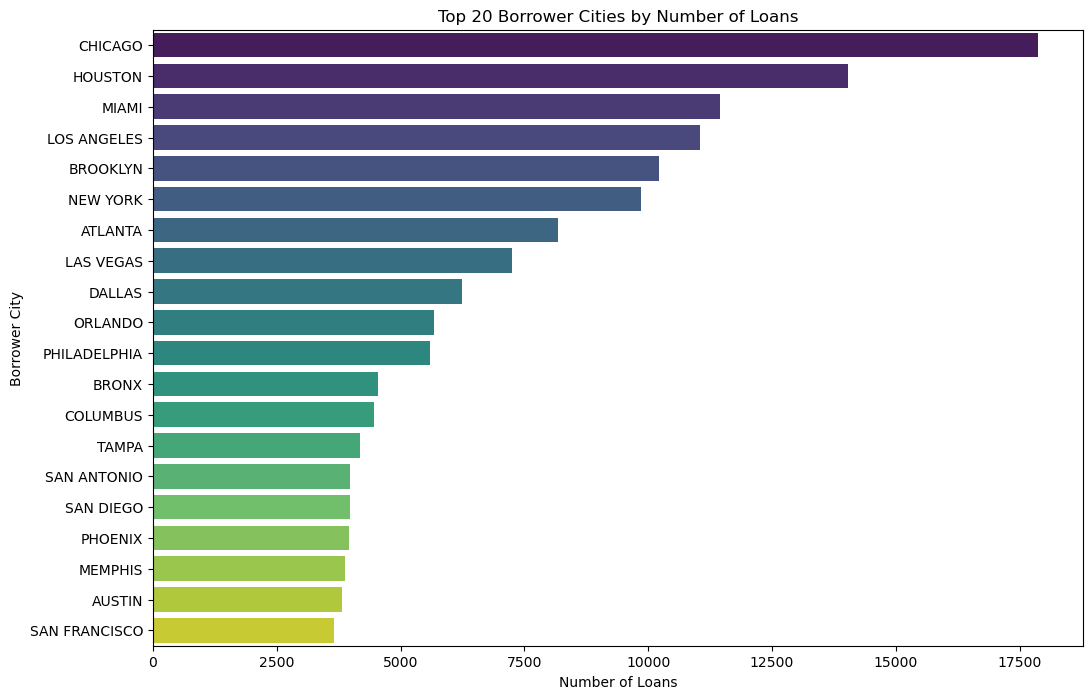

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns


all_sampled_data_df['BorrowerCity'] =  all_sampled_data_df['BorrowerCity'].str.upper()
# Count the number of loans for each city
city_counts = all_sampled_data_df['BorrowerCity'].value_counts().reset_index()
city_counts.columns = ['BorrowerCity', 'LoanCount']

# Select the top 20 cities for visualization purposes
top_cities = city_counts.head(20)

# Create a bar plot of the number of loans per city
plt.figure(figsize=(12, 8))
sns.barplot(data=top_cities, x='LoanCount', y='BorrowerCity', palette='viridis')
plt.title('Top 20 Borrower Cities by Number of Loans')
plt.xlabel('Number of Loans')
plt.ylabel('Borrower City')
plt.show()

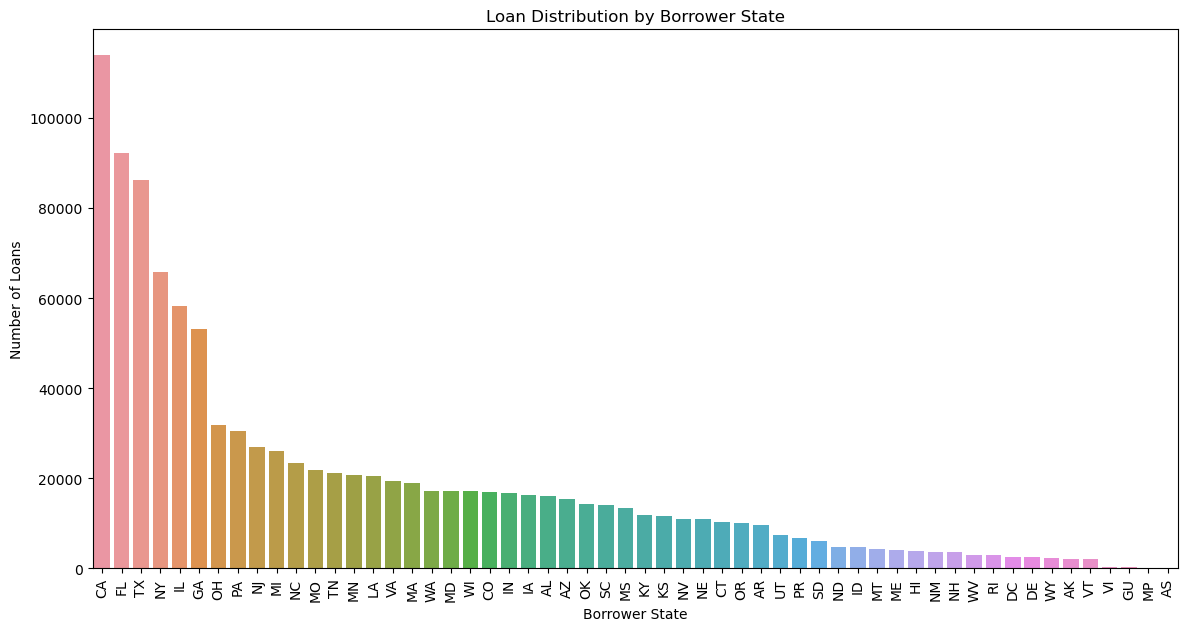

In [40]:
plt.figure(figsize=(14, 7))
sns.countplot(data=all_sampled_data_df, x='BorrowerState', order=all_sampled_data_df['BorrowerState'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Loan Distribution by Borrower State')
plt.xlabel('Borrower State')
plt.ylabel('Number of Loans')
plt.show()


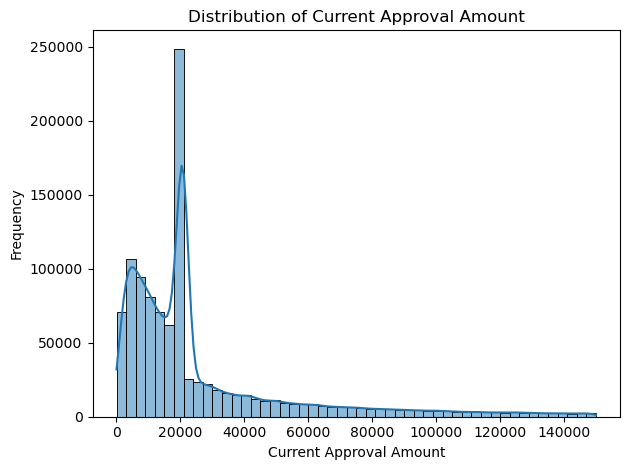

In [41]:

sns.histplot(all_sampled_data_df['CurrentApprovalAmount'], bins=50, kde=True)
plt.title('Distribution of Current Approval Amount')
plt.xlabel('Current Approval Amount')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

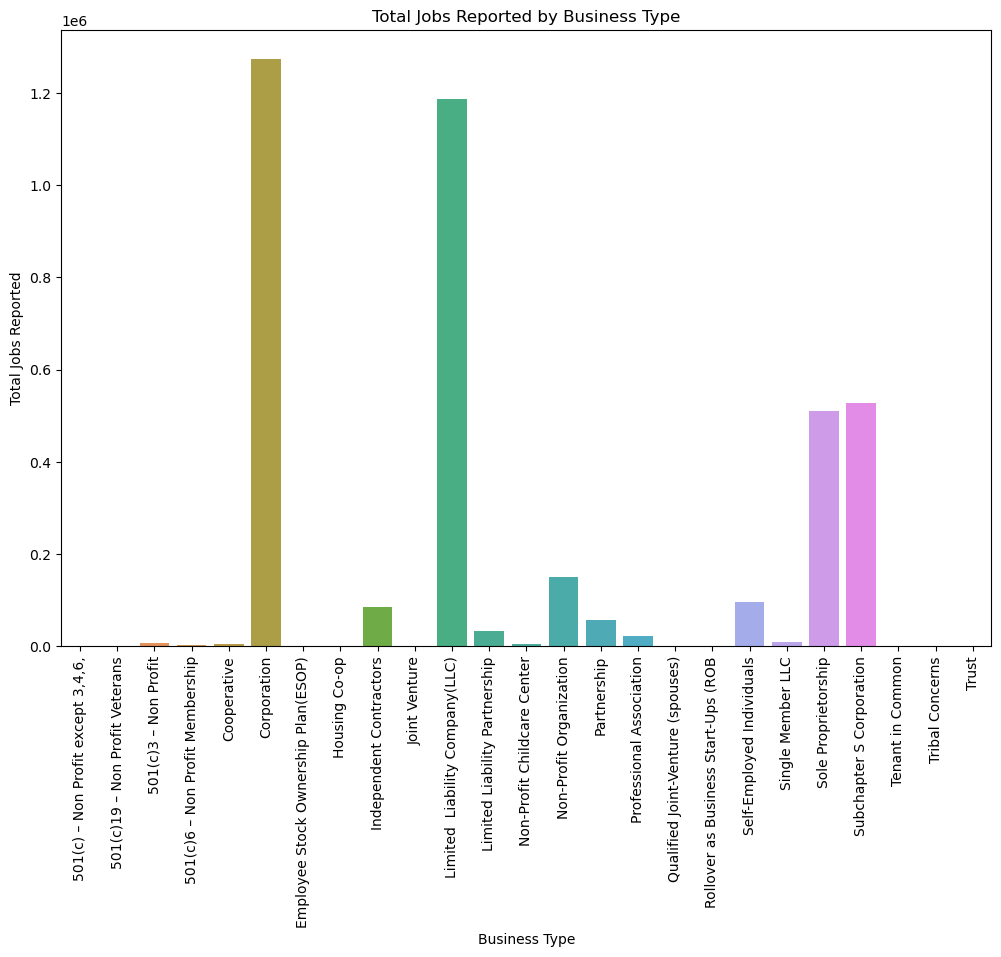

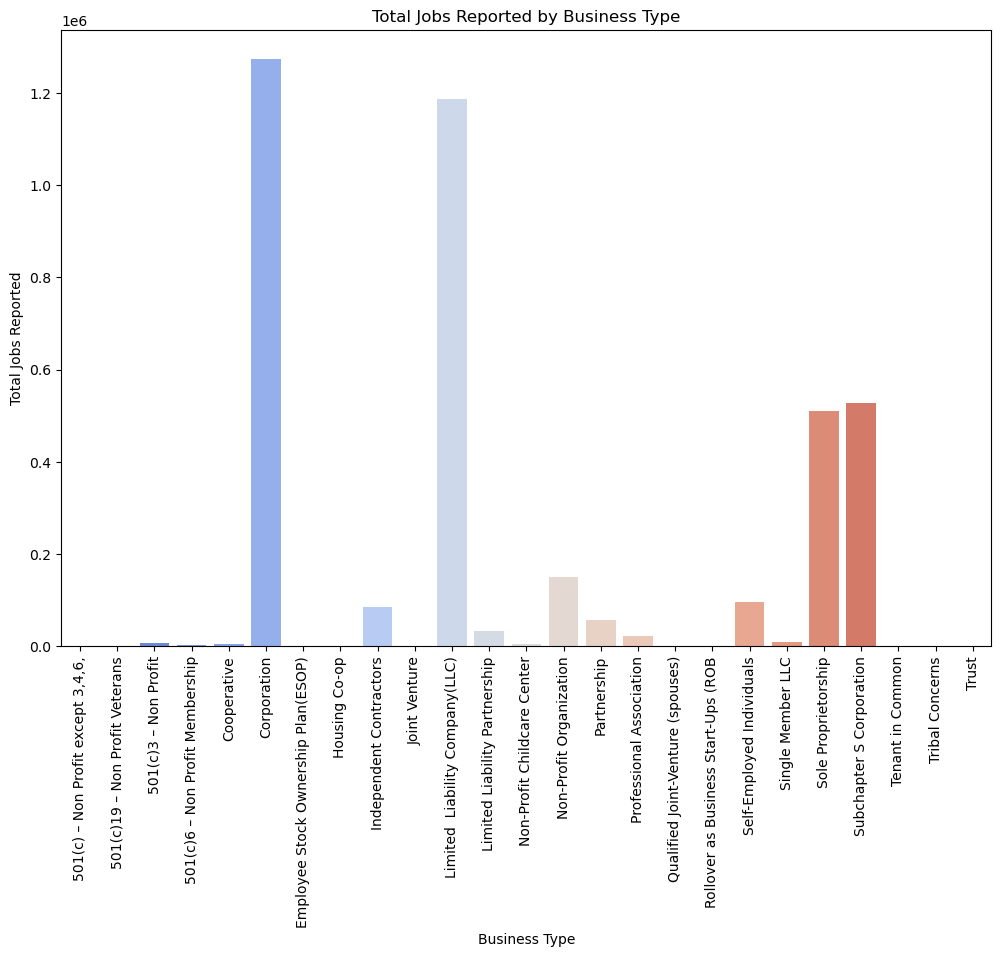

In [42]:
business_jobs = all_sampled_data_df.groupby('BusinessType')['JobsReported'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=business_jobs.index, y=business_jobs.values)
plt.xticks(rotation=90)
plt.title('Total Jobs Reported by Business Type')
plt.xlabel('Business Type')
plt.ylabel('Total Jobs Reported')
plt.show()


# Create a custom color palette
custom_palette = sns.color_palette("coolwarm", len(business_jobs))

# Plot the data using the custom color palette
plt.figure(figsize=(12, 8))
sns.barplot(x=business_jobs.index, y=business_jobs.values, palette=custom_palette)
plt.xticks(rotation=90)
plt.title('Total Jobs Reported by Business Type')
plt.xlabel('Business Type')
plt.ylabel('Total Jobs Reported')
plt.show()


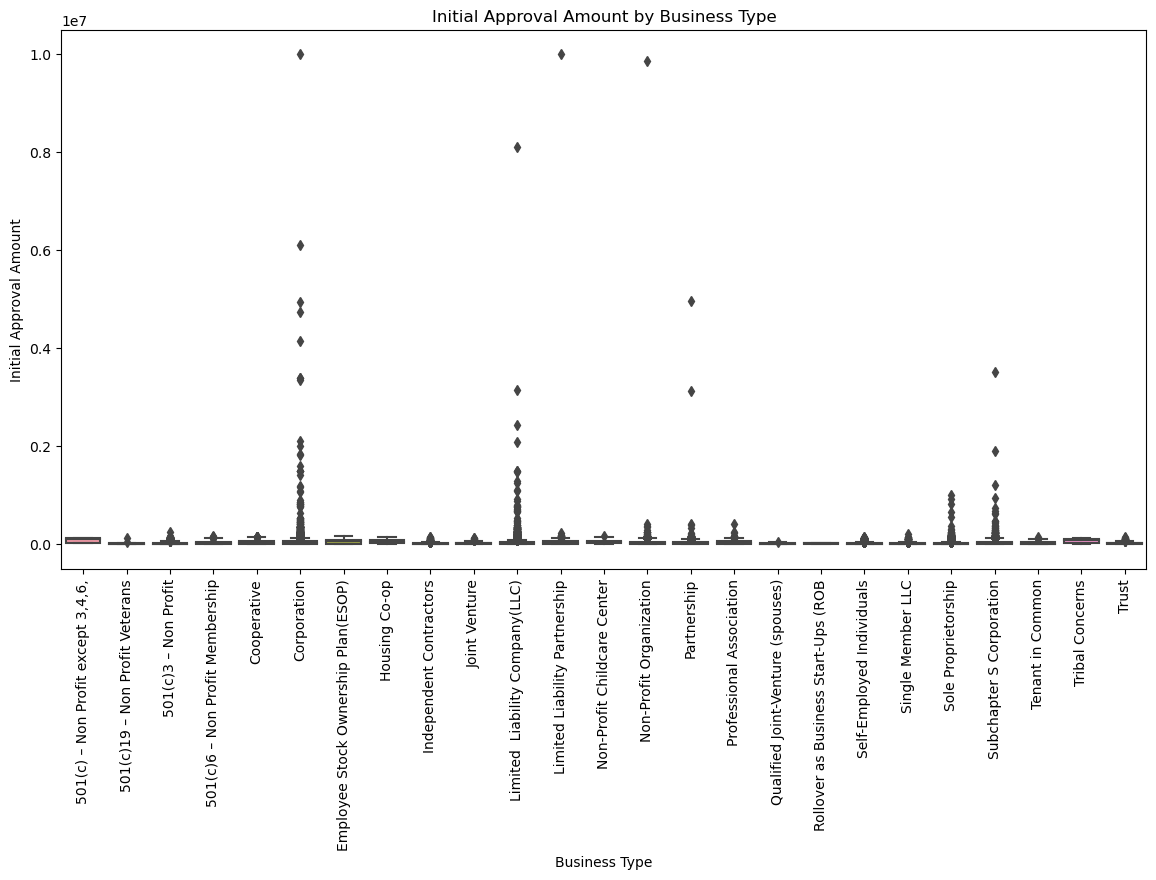

In [43]:
# Box plot for InitialApprovalAmount by BusinessType
plt.figure(figsize=(14, 7))
sns.boxplot(data=all_sampled_data_df, x='BusinessType', y='InitialApprovalAmount')
plt.xticks(rotation=90)
plt.title('Initial Approval Amount by Business Type')
plt.xlabel('Business Type')
plt.ylabel('Initial Approval Amount')
plt.show()


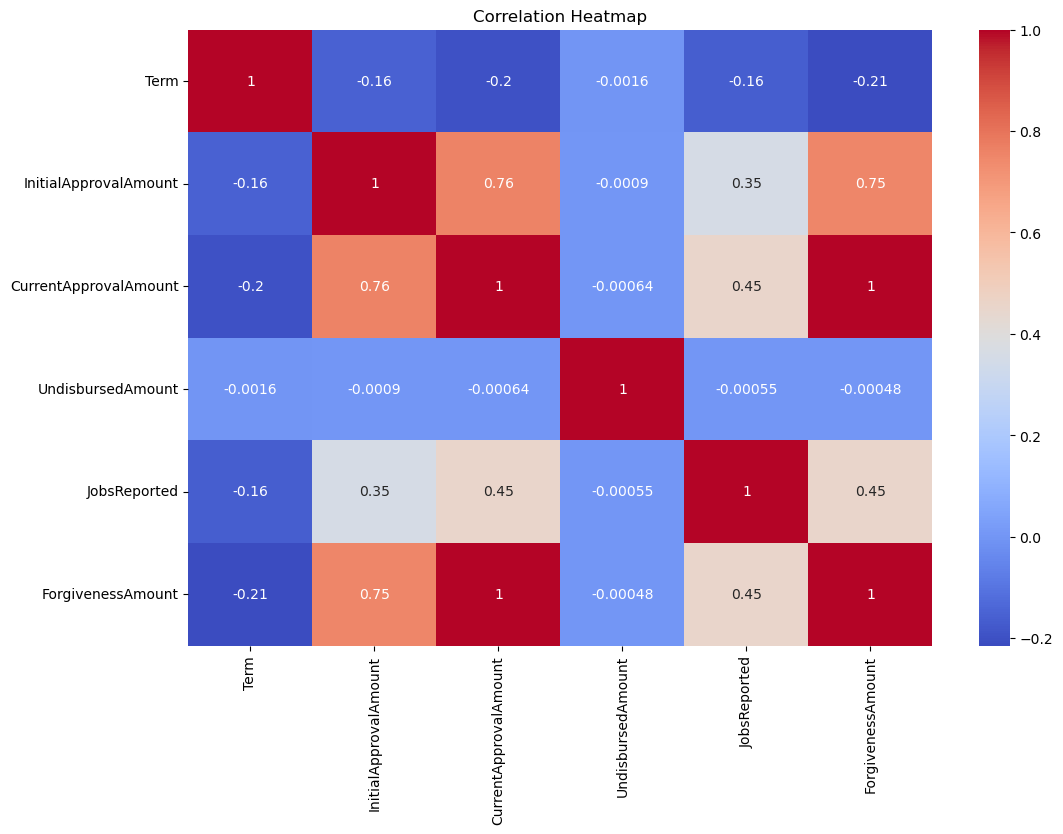

In [44]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
corr = all_sampled_data_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [45]:
print(all_sampled_data_df.dtypes)

LoanNumber                 object
DateApproved               object
BorrowerName               object
BorrowerCity               object
BorrowerState              object
BorrowerZip                object
LoanStatusDate             object
LoanStatus               category
Term                        Int32
InitialApprovalAmount     float32
CurrentApprovalAmount     float32
UndisbursedAmount         float32
ServicingLenderName        object
ServicingLenderCity        object
ServicingLenderState       object
JobsReported              float32
Race                     category
Ethnicity                category
BusinessType             category
Gender                   category
Veteran                  category
ForgivenessAmount         float32
ForgivenessDate            object
dtype: object


In [46]:
# Convert Race and BusinessType to 'category'
all_sampled_data_df['Race'] = all_sampled_data_df['Race'].astype('category')
all_sampled_data_df['BusinessType'] = all_sampled_data_df['BusinessType'].astype('category')
print(all_sampled_data_df.dtypes)

LoanNumber                 object
DateApproved               object
BorrowerName               object
BorrowerCity               object
BorrowerState              object
BorrowerZip                object
LoanStatusDate             object
LoanStatus               category
Term                        Int32
InitialApprovalAmount     float32
CurrentApprovalAmount     float32
UndisbursedAmount         float32
ServicingLenderName        object
ServicingLenderCity        object
ServicingLenderState       object
JobsReported              float32
Race                     category
Ethnicity                category
BusinessType             category
Gender                   category
Veteran                  category
ForgivenessAmount         float32
ForgivenessDate            object
dtype: object


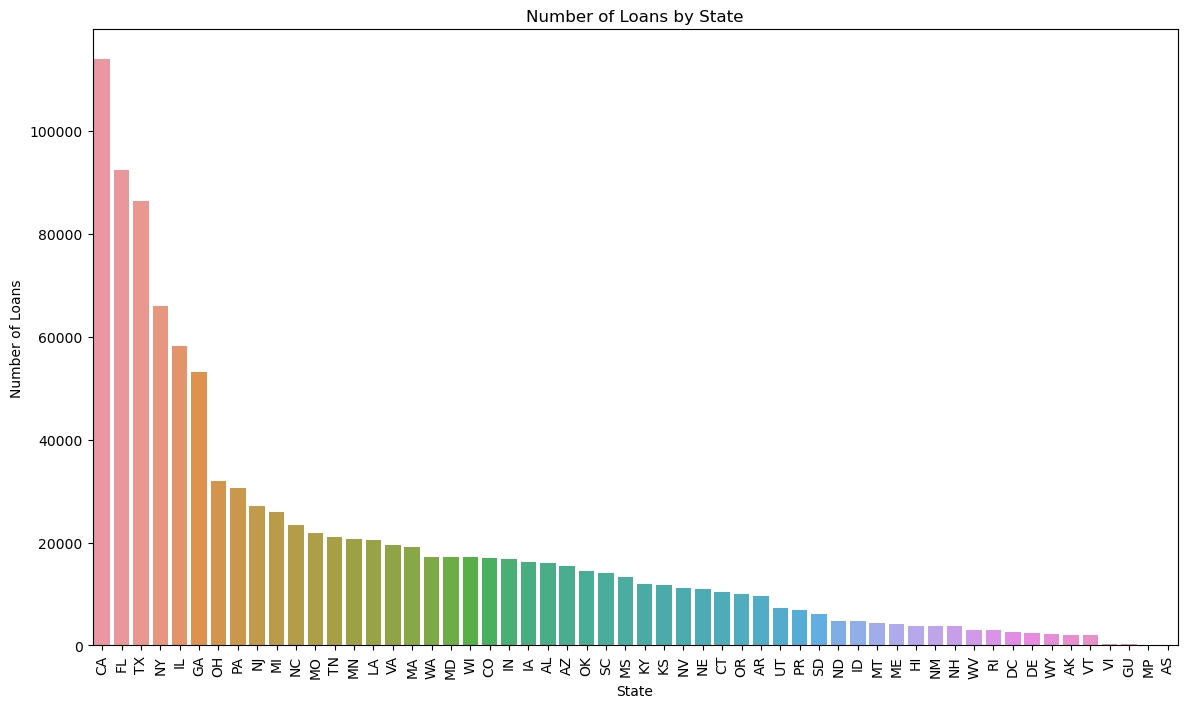

In [47]:
# Number of loans by state
plt.figure(figsize=(14, 8))
state_counts = all_sampled_data_df['BorrowerState'].value_counts()
sns.barplot(x=state_counts.index, y=state_counts.values)
plt.xticks(rotation=90)
plt.title('Number of Loans by State')
plt.xlabel('State')
plt.ylabel('Number of Loans')
plt.show()

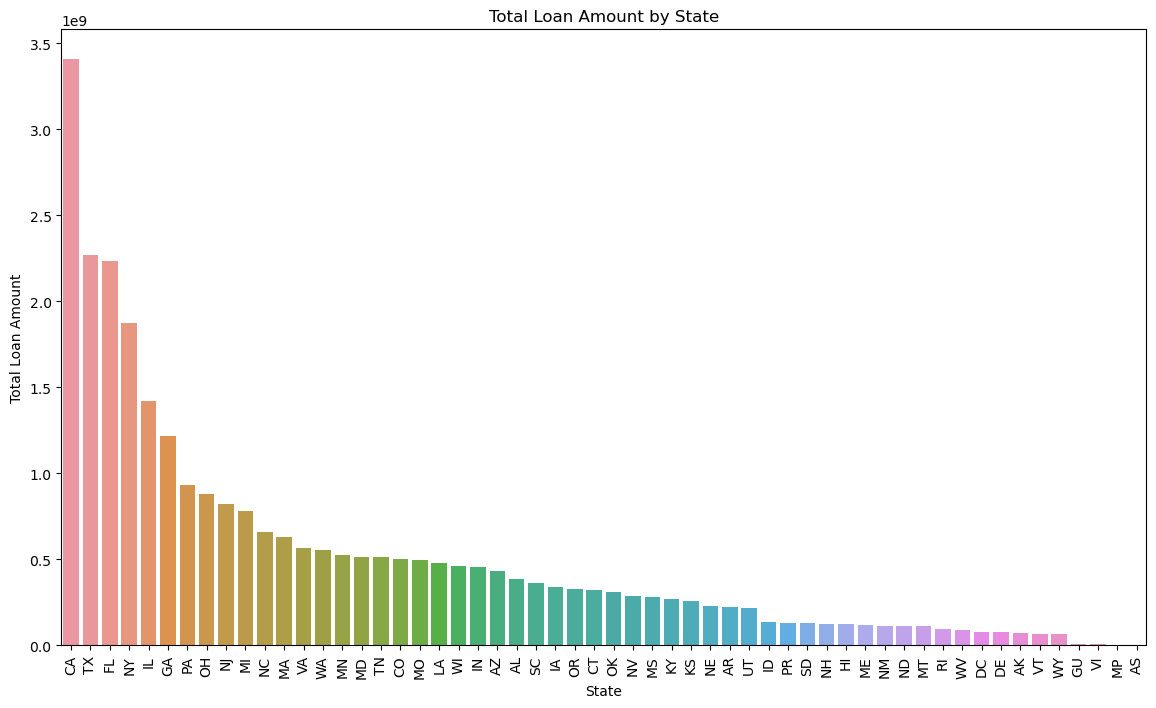

In [48]:
# Total loan amount by state
plt.figure(figsize=(14, 8))
state_loan_amounts = all_sampled_data_df.groupby('BorrowerState')['InitialApprovalAmount'].sum().sort_values(ascending=False)
sns.barplot(x=state_loan_amounts.index, y=state_loan_amounts.values)
plt.xticks(rotation=90)
plt.title('Total Loan Amount by State')
plt.xlabel('State')
plt.ylabel('Total Loan Amount')
plt.show()

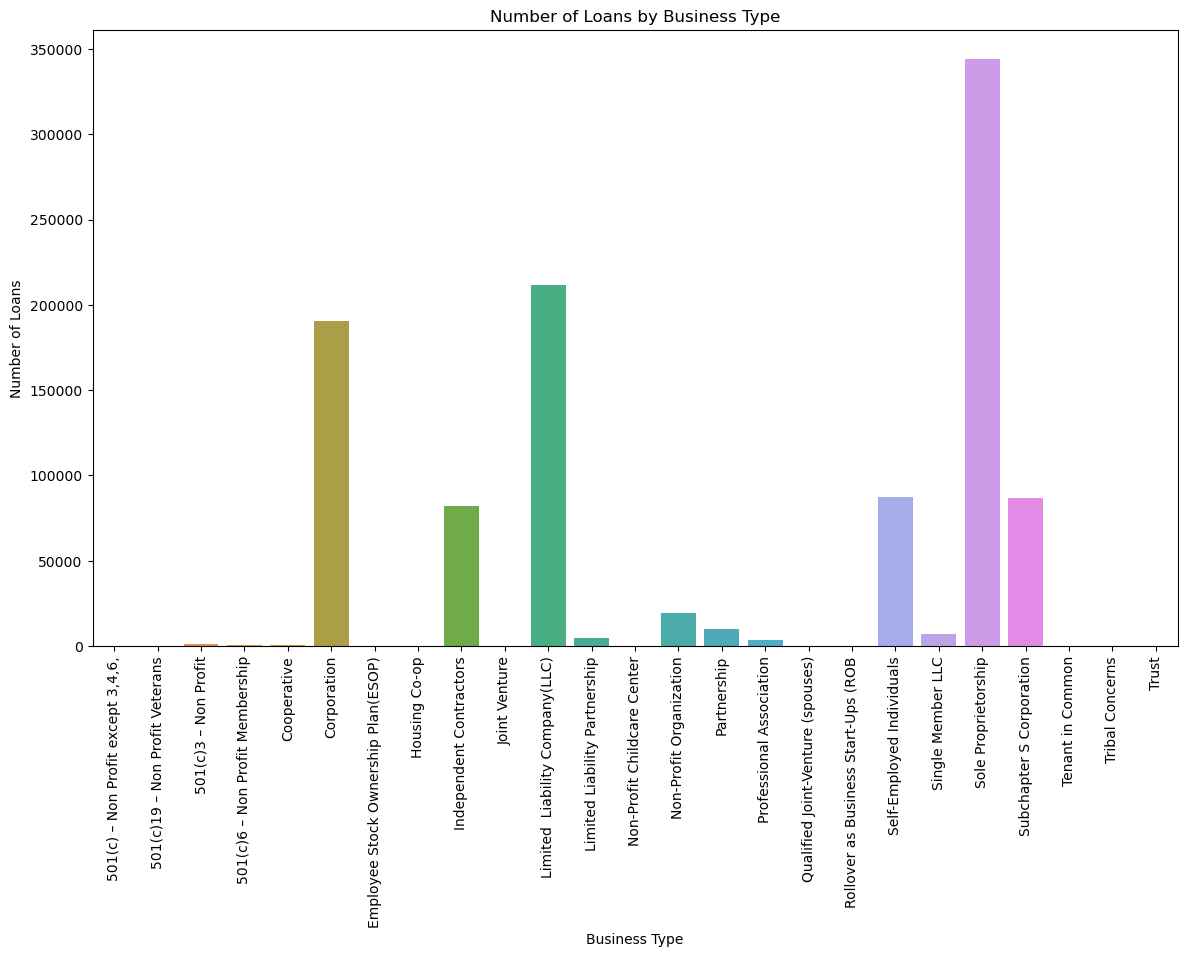

In [49]:
# Number of loans by business type
plt.figure(figsize=(14, 8))
business_type_counts =all_sampled_data_df['BusinessType'].value_counts()
sns.barplot(x=business_type_counts.index, y=business_type_counts.values)
plt.xticks(rotation=90)
plt.title('Number of Loans by Business Type')
plt.xlabel('Business Type')
plt.ylabel('Number of Loans')
plt.show()

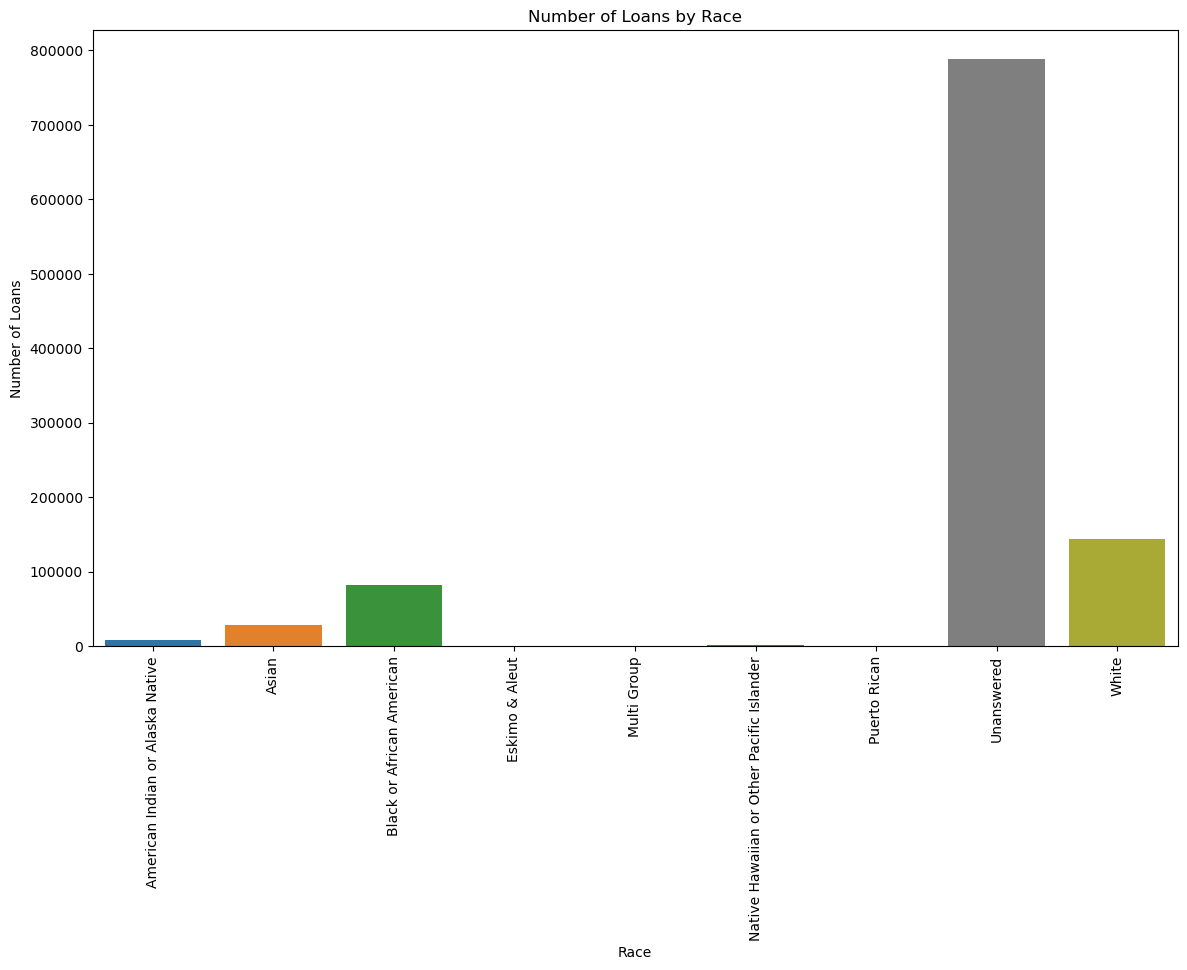

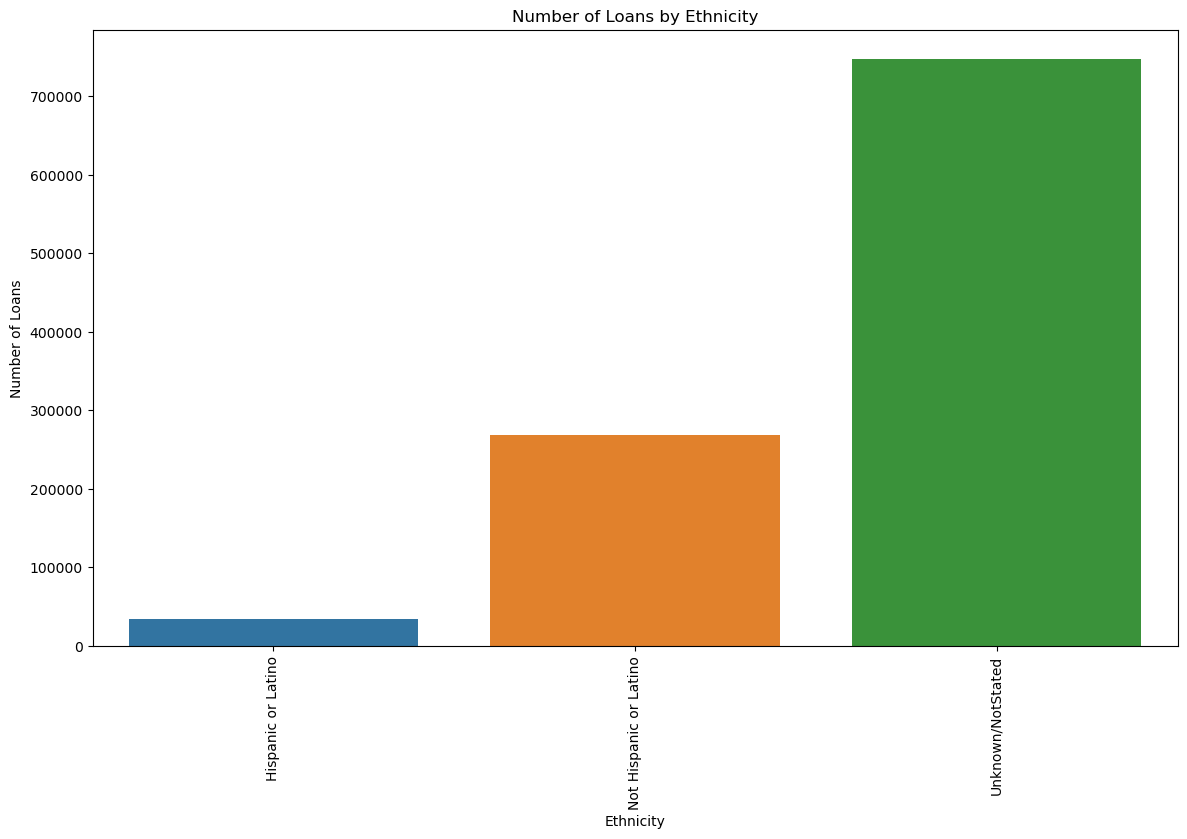

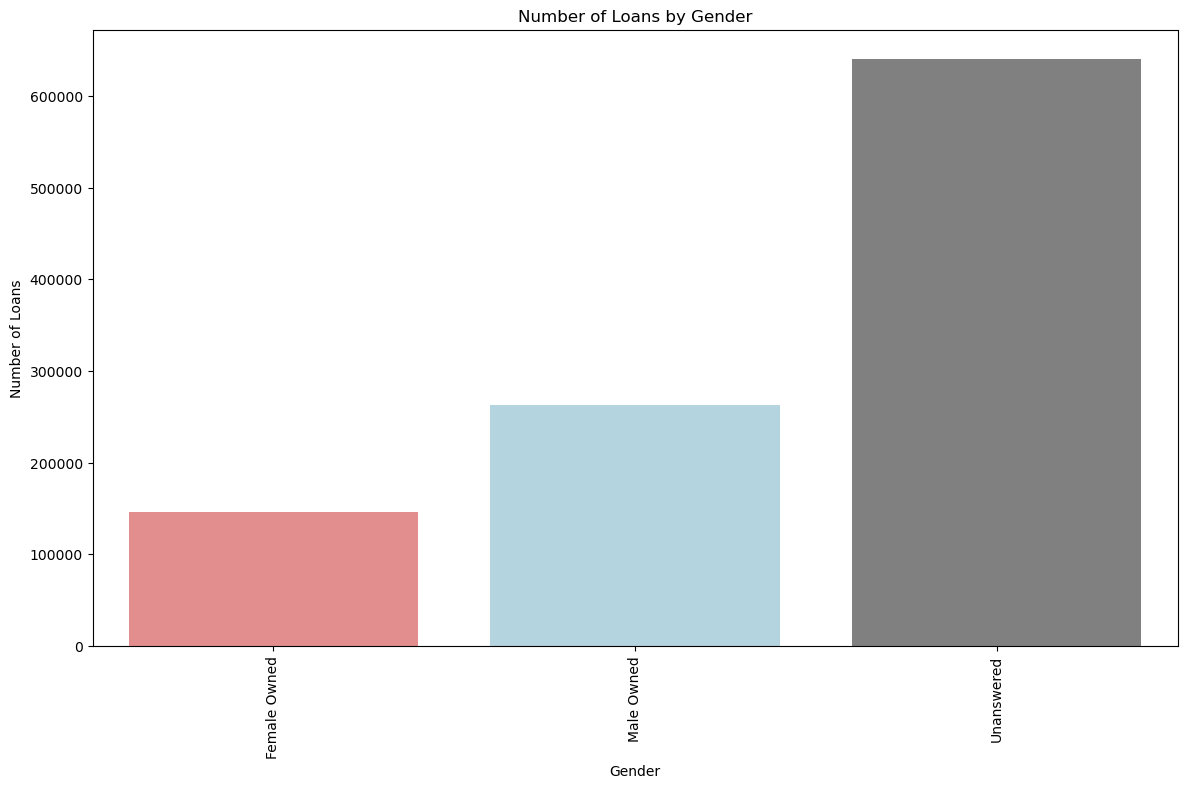

In [50]:
# Insights on demographics: Race and Ethnicity
plt.figure(figsize=(14, 8))
race_counts = all_sampled_data_df['Race'].value_counts()
sns.barplot(x=race_counts.index, y=race_counts.values)
plt.xticks(rotation=90)
plt.title('Number of Loans by Race')
plt.xlabel('Race')
plt.ylabel('Number of Loans')
plt.show()

plt.figure(figsize=(14, 8))
ethnicity_counts =all_sampled_data_df['Ethnicity'].value_counts()
sns.barplot(x=ethnicity_counts.index, y=ethnicity_counts.values)
plt.xticks(rotation=90)
plt.title('Number of Loans by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Number of Loans')
plt.show()

custom_colors = ['lightcoral', 'lightblue', 'grey']

plt.figure(figsize=(14, 8))
ethnicity_counts =all_sampled_data_df['Gender'].value_counts()
sns.barplot(x=ethnicity_counts.index, y=ethnicity_counts.values, palette=custom_colors)
plt.xticks(rotation=90)
plt.title('Number of Loans by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Loans')
plt.show()

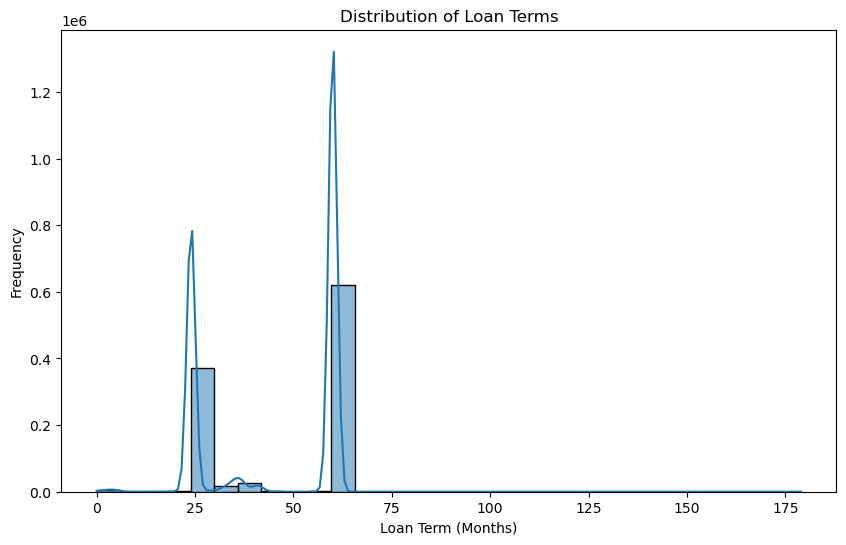

In [51]:
# Check the distribution of loan terms
plt.figure(figsize=(10, 6))
sns.histplot(all_sampled_data_df['Term'], bins=30, kde=True)
plt.title('Distribution of Loan Terms')
plt.xlabel('Loan Term (Months)')
plt.ylabel('Frequency')
plt.show()

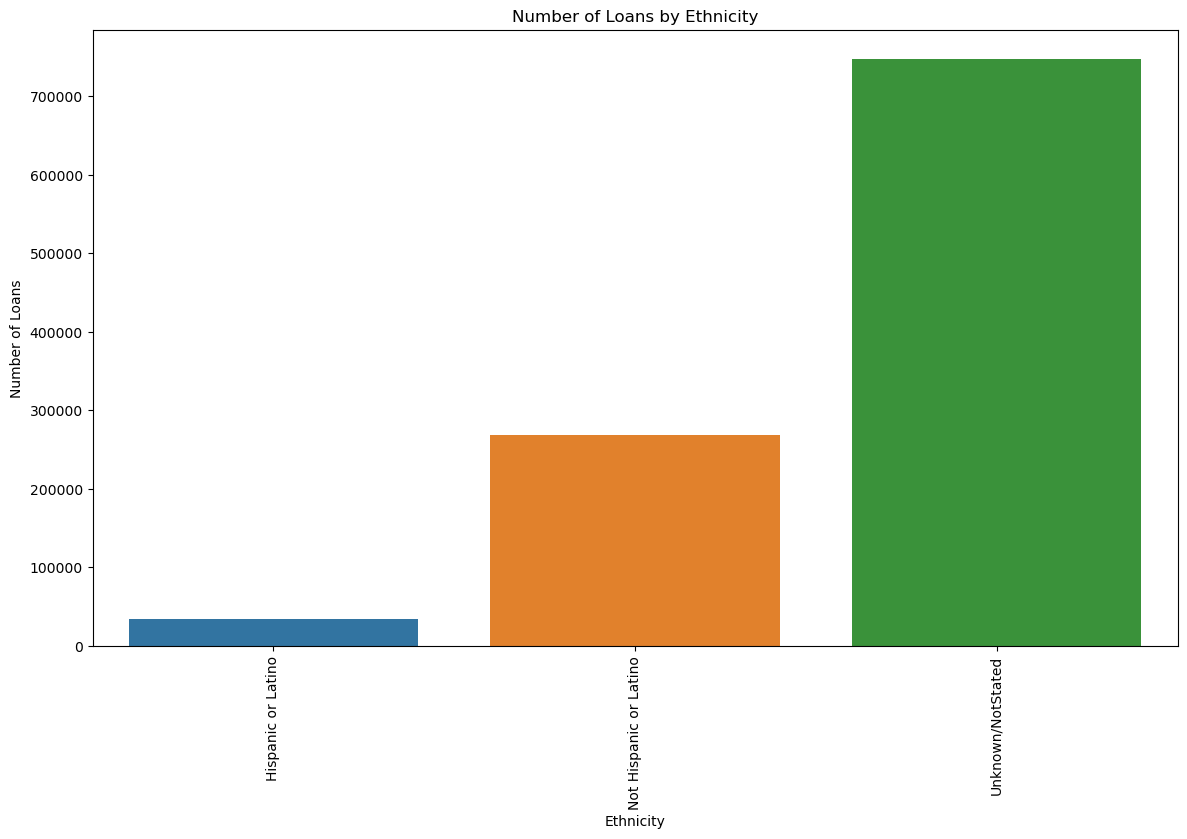

In [52]:
plt.figure(figsize=(14, 8))
ethnicity_counts =all_sampled_data_df['Ethnicity'].value_counts()
sns.barplot(x=ethnicity_counts.index, y=ethnicity_counts.values)
plt.xticks(rotation=90)
plt.title('Number of Loans by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Number of Loans')
plt.show()


**OUTPUT DATA SECTION**

In [53]:
# Step 1: Aggregate loan amounts by state
state_loan_totals = all_sampled_data_df.groupby('BorrowerState')['CurrentApprovalAmount'].sum().reset_index()
state_loan_totals.rename(columns={'CurrentApprovalAmount': 'TotalLoanAmount'}, inplace=True)
#print(state_loan_totals)


In [54]:
# Step 2: Merge Loan data with population estimates
# Extract only the relevant columns from population data
pop_est_df_relevant = pop_est_df[['STNAME', 'POPESTIMATE2023']]
pop_est_df_relevant = pop_est_df_relevant.groupby('STNAME').sum().reset_index()

print(pop_est_df_relevant)

                  STNAME  POPESTIMATE2023
0                Alabama         10216936
1                 Alaska          1466812
2                Arizona         14862688
3               Arkansas          6135464
4             California         77930386
5               Colorado         11755220
6            Connecticut          7234352
7               Delaware          2063780
8   District of Columbia          1357944
9                Florida         45221452
10               Georgia         22058454
11                Hawaii          2870276
12                 Idaho          3929452
13              Illinois         25099378
14               Indiana         13724398
15                  Iowa          6414008
16                Kansas          5881092
17              Kentucky          9052308
18             Louisiana          9147498
19                 Maine          2791444
20              Maryland         12360506
21         Massachusetts         14002798
22              Michigan         2

We observe that while in the PPP data the state name is denoted by only 2 letters , in the population estimate the state is defined by the whole name of the state and that will be a problem when we will try to merge those. We have to do again a mapping in order to map the coded state name of the one dataset (PPP data) with the state name of the other dataset.

In [55]:
# Dictionary to map state decoded states to full state names
state_mapping = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'DC': 'District of Columbia', 
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 
    'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 
    'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 
    'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 
    'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 
    'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 
    'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 
    'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming',
    'AS': 'American Samoa', 'GU': 'Guam', 'MP': 'Northern Mariana Islands', 'VI': 'Virgin Islands'
}

In [56]:
# Aggregate loan amounts by state
state_loan_totals = all_sampled_data_df.groupby('BorrowerState')['CurrentApprovalAmount'].sum().reset_index()
state_loan_totals.rename(columns={'CurrentApprovalAmount': 'TotalLoanAmount'}, inplace=True)

# Map state abbreviations to full state names
state_loan_totals['BorrowerState'] = state_loan_totals['BorrowerState'].map(state_mapping)
print(state_loan_totals)

               BorrowerState  TotalLoanAmount
0                     Alaska     7.209038e+07
1                    Alabama     3.836149e+08
2                   Arkansas     2.245570e+08
3             American Samoa     6.151612e+05
4                    Arizona     4.274727e+08
5                 California     3.367008e+09
6                   Colorado     4.957762e+08
7                Connecticut     3.208443e+08
8       District of Columbia     7.934364e+07
9                   Delaware     7.489739e+07
10                   Florida     2.194536e+09
11                   Georgia     1.194599e+09
12                      Guam     9.967102e+06
13                    Hawaii     1.202313e+08
14                      Iowa     3.431319e+08
15                     Idaho     1.348688e+08
16                  Illinois     1.412762e+09
17                   Indiana     4.530556e+08
18                    Kansas     2.611003e+08
19                  Kentucky     2.685509e+08
20                 Louisiana     4

In [57]:
# Summarize population estimates by state
pop_est_df_relevant = pop_est_df[['STNAME', 'POPESTIMATE2023']]
pop_est_df_relevant = pop_est_df_relevant.groupby('STNAME')['POPESTIMATE2023'].sum().reset_index()

In [58]:
# Merge PPP data with population estimation data
merged_df = state_loan_totals.merge(pop_est_df_relevant, left_on='BorrowerState', right_on='STNAME', how='left')

# Display the merged DataFrame
print(merged_df)

               BorrowerState  TotalLoanAmount                STNAME  \
0                     Alaska     7.209038e+07                Alaska   
1                    Alabama     3.836149e+08               Alabama   
2                   Arkansas     2.245570e+08              Arkansas   
3             American Samoa     6.151612e+05                   NaN   
4                    Arizona     4.274727e+08               Arizona   
5                 California     3.367008e+09            California   
6                   Colorado     4.957762e+08              Colorado   
7                Connecticut     3.208443e+08           Connecticut   
8       District of Columbia     7.934364e+07  District of Columbia   
9                   Delaware     7.489739e+07              Delaware   
10                   Florida     2.194536e+09               Florida   
11                   Georgia     1.194599e+09               Georgia   
12                      Guam     9.967102e+06                   NaN   
13    

In [59]:
# Calculate Total Loan Amount per 100k residents
merged_df['TotalLoanAmountPer100kResidents'] = (merged_df['TotalLoanAmount'] / merged_df['POPESTIMATE2023']) * 100000

In [60]:
print(merged_df.head(10))
print(merged_df.info())

          BorrowerState  TotalLoanAmount                STNAME  \
0                Alaska     7.209038e+07                Alaska   
1               Alabama     3.836149e+08               Alabama   
2              Arkansas     2.245570e+08              Arkansas   
3        American Samoa     6.151612e+05                   NaN   
4               Arizona     4.274727e+08               Arizona   
5            California     3.367008e+09            California   
6              Colorado     4.957762e+08              Colorado   
7           Connecticut     3.208443e+08           Connecticut   
8  District of Columbia     7.934364e+07  District of Columbia   
9              Delaware     7.489739e+07              Delaware   

   POPESTIMATE2023  TotalLoanAmountPer100kResidents  
0        1466812.0                     4.914766e+06  
1       10216936.0                     3.754696e+06  
2        6135464.0                     3.659984e+06  
3              NaN                              NaN  
4  

In [61]:
# Remove rows with NaN values
merged_df = merged_df.dropna()


In [62]:
print(merged_df.head())
print(merged_df.info())

  BorrowerState  TotalLoanAmount      STNAME  POPESTIMATE2023  \
0        Alaska     7.209038e+07      Alaska        1466812.0   
1       Alabama     3.836149e+08     Alabama       10216936.0   
2      Arkansas     2.245570e+08    Arkansas        6135464.0   
4       Arizona     4.274727e+08     Arizona       14862688.0   
5    California     3.367008e+09  California       77930386.0   

   TotalLoanAmountPer100kResidents  
0                     4.914766e+06  
1                     3.754696e+06  
2                     3.659984e+06  
4                     2.876147e+06  
5                     4.320533e+06  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 55
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BorrowerState                    51 non-null     object 
 1   TotalLoanAmount                  51 non-null     float32
 2   STNAME                          

In [63]:
print(merged_df)

           BorrowerState  TotalLoanAmount                STNAME  \
0                 Alaska     7.209038e+07                Alaska   
1                Alabama     3.836149e+08               Alabama   
2               Arkansas     2.245570e+08              Arkansas   
4                Arizona     4.274727e+08               Arizona   
5             California     3.367008e+09            California   
6               Colorado     4.957762e+08              Colorado   
7            Connecticut     3.208443e+08           Connecticut   
8   District of Columbia     7.934364e+07  District of Columbia   
9               Delaware     7.489739e+07              Delaware   
10               Florida     2.194536e+09               Florida   
11               Georgia     1.194599e+09               Georgia   
13                Hawaii     1.202313e+08                Hawaii   
14                  Iowa     3.431319e+08                  Iowa   
15                 Idaho     1.348688e+08                 Idah

In [72]:
# Save the merged DataFrame to a CSV file

output_path = r"C:\Users\kosti\OneDrive\Desktop\Data Engineering\Homework2\CovidRecovery\Output\Total_Loan_Amount_per_100k_residents.csv"

# Saving the dataframe
merged_df.to_csv(output_path, index=False)

In [70]:
# Format the columns to display numbers with fewer decimal points
pd.options.display.float_format = '{:,.2f}'.format

# Convert the necessary columns to display numbers in a readable format
merged_df['TotalLoanAmount'] = merged_df['TotalLoanAmount'].astype(float).map('{:,.2f}'.format)
merged_df['TotalLoanAmountPer100kResidents'] = merged_df['TotalLoanAmountPer100kResidents'].astype(float).map('{:,.2f}'.format)



ValueError: could not convert string to float: '72,090,384.00'

In [71]:
merged_df = merged_df.sort_values(by='TotalLoanAmountPer100kResidents', ascending=False)

# Select the top 20 rows
top_20_df = merged_df.head(20)

# Save the top 20 rows as an HTML file for reporting
top_20_df.to_html('C:/Users/kosti/OneDrive/Desktop/Data Engineering/Homework2/CovidRecovery/Output/top_20_merged_dataframe.html', index=False)

# Display the formatted dataframe
print(top_20_df)

           BorrowerState   TotalLoanAmount                STNAME  \
31          North Dakota    115,378,856.00          North Dakota   
45          South Dakota    131,262,912.00          South Dakota   
32              Nebraska    231,835,296.00              Nebraska   
8   District of Columbia     79,343,640.00  District of Columbia   
16              Illinois  1,412,761,728.00              Illinois   
55               Wyoming     64,247,328.00               Wyoming   
11               Georgia  1,194,599,040.00               Georgia   
14                  Iowa    343,131,936.00                  Iowa   
20             Louisiana    478,641,152.00             Louisiana   
51               Vermont     65,222,280.00               Vermont   
0                 Alaska     72,090,384.00                Alaska   
29               Montana    110,943,240.00               Montana   
10               Florida  2,194,535,680.00               Florida   
28           Mississippi    279,033,376.00      